In [1]:
''' (C) Copyright IBM Corp. 2024.
    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
           http://www.apache.org/licenses/LICENSE-2.0
     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
 Project name: Model Urban Growth MUG
'''

' (C) Copyright IBM Corp. 2024.\n    Licensed under the Apache License, Version 2.0 (the "License");\n    you may not use this file except in compliance with the License.\n    You may obtain a copy of the License at\n           http://www.apache.org/licenses/LICENSE-2.0\n     Unless required by applicable law or agreed to in writing, software\n     distributed under the License is distributed on an "AS IS" BASIS,\n     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n     See the License for the specific language governing permissions and\n     limitations under the License.\n Project name: Model Urban Growth MUG\n'

In [2]:
%load_ext autoreload
%autoreload 2

## Sequence to Sequence model to identify urban areas

#### This notebook performs a training, validation and testing of a sequence-to-sequence convLSTM model to predict urban settlements. The model training used a time series from Worldpop.org between 2000 and 2004 and the test carried out used data from the year 2005.

### Import packages

In [3]:
import random
import numpy as np
from math import floor
import pandas as pd
import os
import json

from datetime import datetime

import mug.datasets.worldpop as wp
from mug.nn import SequenceToSequence
from mug.datasets import ForecastingDataset
from mug.datasets.utils import unbind_sequence
from mug.samplers import ForecastingGridGeoSampler, ForecastingRandomGeoSampler
from mug.samplers import RandomMultiSampler, SequentialMultiSampler
from mug.transforms import factor, normalize_binary_land_mask, chain, reclassify_time_differences

import torch
from torch import optim, nn
from torch.utils.data import DataLoader

from torchgeo.datasets import BoundingBox

import time
from torch.profiler import profile, record_function, ProfilerActivity

from mug.transforms import factor, normalize_binary_land_mask, chain, reclassify_time_differences

from mug.utils.metrics import MyAccuracy
from mug.utils.functions import target_mask, class_mask, pred_mask
from mug.utils.loss import LossComputation,LossPlotter, AccPlotter


In [4]:
def year(y: int) -> float:
    return datetime(y,1,1).timestamp()

### Dataset and config variables

In [64]:
# SAMPLING

SIZE = 120
START_YEAR = 2000  # start year
SEQUENCE = 5  # number of time steps to train on (plus one as target)
ROI_FILE="rois.csv"  # this file should be in the root of the project
ROI_COUNTRIES = []  # list of country codes to sample from, all if empty
TRAINING_SAMPLES = 512  # total number of training samples
ROI_SAMPLES = 32  # number of samples per ROI (only valid if random)
SEED = 5040

# DATA
DATA_DIR="../../../worldpop/" #Download the worldpop and ESA data , vide README to access the link

# COMPUTE RELATED

ACCELERATOR = "gpu"
PRECISION = 16
NUM_WORKERS = 1

# TRAINING HYPERPARAMETERS

STRIDE = 115
NUM_CLASSES = 4
BATCH_SIZE = 32 
NUM_EPOCHS = 75

INPUT_CHANNELS = 5
LEARNING_RATE = 1e-4
TARGET_SEQUENCE = 1

# SAVING MODELS 
SAVING_DIR = "saved_models/tb_logs/"  
os.makedirs(SAVING_DIR, exist_ok=True)

## Data from worldpop

In [42]:
uds = wp.UrbanLandCover(cache=True, root=DATA_DIR,
                        transforms=lambda sample: chain(sample, transforms=[normalize_binary_land_mask, 
                                                                            reclassify_time_differences]))
cds = wp.CropLandCover(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
wds = wp.Water(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
rds = wp.Roads(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
sds = wp.Slope(cache=True, root=DATA_DIR, transforms=lambda sample: factor(sample, weight=1./90.))
#vds = wp.VegetationLandCover(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
#bds = wp.BareLandCover(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
#gds = wp.GrassLandCover(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)
#eds = wp.Elevation(cache=True, root=DATA_DIR, transforms=lambda sample: factor(sample, weight=.01))
#pds = wp.Population(cache=True, root=DATA_DIR, transforms=lambda sample: factor(sample, weight=.001))
#fds = wp.FloodedLandCover(cache=True, root=DATA_DIR, transforms=normalize_binary_land_mask)

In [43]:
variates = [uds]
covariates =  [cds, wds, rds, sds]
worldpop = ForecastingDataset(variates, covariates)

Converting Roads res from 0.0008333333299999999 to 0.00083333333
Converting Slope res from 0.0008333333300000233 to 0.00083333333


In [44]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [45]:
# Load ROIs
set_seed(SEED)

rois = pd.read_csv(ROI_FILE)
if ROI_COUNTRIES:
    rois = rois[rois['COUNTRY'].isin(ROI_COUNTRIES)]

n = max(1, floor(TRAINING_SAMPLES / ROI_SAMPLES))
if n > len(rois):
    raise ValueError("Not enough ROIs.")
rois = rois.sample(n=n, replace=False)

# Instantiate BoundingBox objects
bboxes = [
    BoundingBox(
        minx=roi['MINX'],
        maxx=roi['MAXX'],
        miny=roi['MINY'],
        maxy=roi['MAXY'],
        mint=year(START_YEAR),
        maxt=year(START_YEAR + SEQUENCE),
    ) for _, roi in rois.iterrows()
]

# Split bounding boxes into training, validation, and test sets
num_bboxes = len(bboxes)
train_split_idx, val_split_idx = int(0.8 * num_bboxes), int(0.9 * num_bboxes)
train_bboxes, val_bboxes, test_bboxes = (
    bboxes[:train_split_idx], bboxes[train_split_idx:val_split_idx], bboxes[val_split_idx:]
)

# Create samplers for bounding boxes
def create_samplers(bboxes):
    return tuple(ForecastingRandomGeoSampler(uds, size=SIZE, length=ROI_SAMPLES, roi=bbox) for bbox in bboxes)

train_samplers, val_samplers, test_samplers = map(create_samplers, [train_bboxes, val_bboxes, test_bboxes])

# Create multisamplers
train_multisampler, val_multisampler, test_multisampler = map(RandomMultiSampler, [train_samplers, val_samplers, test_samplers])

# Create DataLoaders
def create_dataloader(sampler):
    return DataLoader(
        worldpop,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        batch_size=BATCH_SIZE,
        collate_fn=lambda batch: unbind_sequence(batch, TARGET_SEQUENCE)
    )

train_dataloader, val_dataloader, test_dataloader = map(create_dataloader, [train_multisampler, val_multisampler, test_multisampler])

# Print number of samples in each DataLoader
for name, dataloader in zip(['training', 'validation', 'test'], [train_dataloader, val_dataloader, test_dataloader]):
    print(f"Number of {name} samples: {len(dataloader.sampler)}")

Number of training samples: 384
Number of validation samples: 64
Number of test samples: 64


### Model

In [10]:
# defining device for computation

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA device is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA device is not available. Using CPU.")
    return device

# Example usage
DEVICE = get_device()

CUDA device is available. Using GPU.


In [11]:
# Sequence to sequence model

model = SequenceToSequence(num_channels=INPUT_CHANNELS,
                           num_kernels=64,
                           kernel_size=(3,3),
                           padding=(1,1),
                           activation="relu",
                           frame_size=(SIZE,SIZE),
                           num_layers=3,).to(DEVICE)
# print(model)

### Training loop

In [12]:
WEIGHT = torch.tensor(
          [[0.30],  # class 0 (water) 
          [0.05],   # class 1 (land)
          [0.50],   # class 2 (non-bs to bs)
          [0.15]],  # class 3 (bs) 
    device=DEVICE)

In [13]:
weight = WEIGHT

best_val_loss = float('inf')
best_model_path = os.path.join(SAVING_DIR, 'best_model_'+str(NUM_EPOCHS)+'.pth')
last_model_path = os.path.join(SAVING_DIR, 'last_model_'+str(NUM_EPOCHS)+'.pth')
best_model_meta_path = os.path.join(SAVING_DIR, 'best_model_meta_'+str(NUM_EPOCHS)+'.json')
last_model_meta_path = os.path.join(SAVING_DIR, 'last_model_meta_'+str(NUM_EPOCHS)+'.json')
history_path = os.path.join(SAVING_DIR, 'training_history_'+str(NUM_EPOCHS)+'.npy')

# Initialize history lists to track losses
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Initialize the LossComputation and MyAccuracy classes
loss_computer = LossComputation(DEVICE, BATCH_SIZE, SIZE, NUM_CLASSES, weight)
accuracy_metric = MyAccuracy(BATCH_SIZE, SIZE, NUM_CLASSES).to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_val_loss = float('inf')

for epoch in range(0, NUM_EPOCHS):
    train_loss = 0.
    print(f"Epoch {epoch+1}: Batch ", end="")

    # Training loop
    model.train()
    for batch_num, (x, y) in enumerate(train_dataloader):
        print(f"{batch_num+1}, ", end="")

        # Preprocess inputs
        # Transpose the tensors to switch the time_steps and number_channels dimensions
        x = torch.transpose(x, 1, 2).to(DEVICE)
        y = torch.transpose(y, 1, 2).squeeze().to(DEVICE)

        # Forward pass
        y_hat = model(x)
        y_hat = y_hat.squeeze()  # match the shape of y
        
        # Compute loss
        loss = loss_computer.compute_loss(y_hat, y)
        
        # backpropagation
        loss.backward()
        
        # iteration updates
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        
        # Update accuracy metric
        accuracy_metric.update(y_hat[:, 0], y[:, 0])

    
    train_loss /= len(train_dataloader.sampler)
    train_accuracy = accuracy_metric.compute().item()
    accuracy_metric.reset()
    print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")


    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_num, (x, y) in enumerate(val_dataloader):
            print(f"{batch_num+1}, ", end="")
            
            # Preprocess inputs
            x = torch.transpose(x, 1, 2).to(DEVICE)
            y = torch.transpose(y, 1, 2).squeeze().to(DEVICE)
            
            # Forward pass
            y_hat = model(x)
            y_hat = y_hat.squeeze()  # match the shape of y

            # Compute loss
            loss = loss_computer.compute_loss(y_hat, y)
            val_loss += loss.item()

            # Update accuracy metric
            accuracy_metric.update(y_hat[:, 0], y[:, 0])

        
        val_loss /= len(val_dataloader.sampler)
        val_accuracy = accuracy_metric.compute().item()
        accuracy_metric.reset()
        print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        best_model_meta = {
            "epoch": epoch + 1,
            "training_loss": train_loss,
            "validation_loss": val_loss,
            "training_accuracy": train_accuracy,
            "validation_accuracy": val_accuracy
        }
        with open(best_model_meta_path, 'w') as f:
            json.dump(best_model_meta, f)
        print(f"Best model saved with validation loss: {best_val_loss:.2f} at {best_model_path}")

    # Save the last model, overwriting each time
    torch.save(model.state_dict(), last_model_path)
    last_model_meta = {
        "epoch": epoch + 1,
        "training_loss": train_loss,
        "validation_loss": val_loss,
        "training_accuracy": train_accuracy,
        "validation_accuracy": val_accuracy
    }
    with open(last_model_meta_path, 'w') as f:
        json.dump(last_model_meta, f)
    print(f"Last model saved: {last_model_path}")

    # Update history
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    np.save(history_path, {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_accuracy': train_accuracy_history,
        'val_accuracy': val_accuracy_history
    })

print("Training complete.")

train loss:  0.5173328345020612
validation loss:  0.5986669063568115


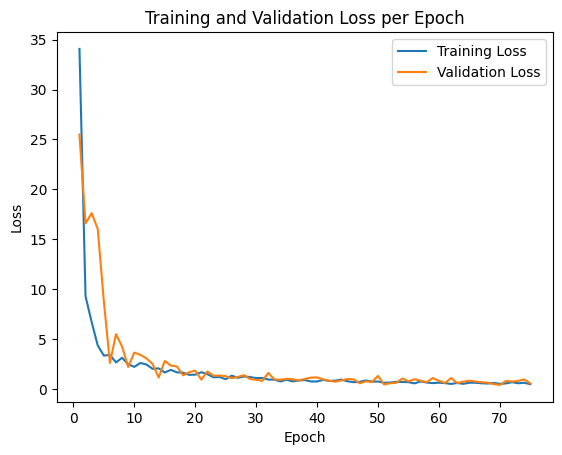

In [15]:
history_path = SAVING_DIR + '/training_history_'+str(NUM_EPOCHS)+'.npy'

# Load the history from the .npy file
history = np.load(history_path, allow_pickle=True).item()

# Extract the train and validation loss histories
train_loss_history = history['train_loss']
val_loss_history = history['val_loss']

print('train loss: ', train_loss_history[-1])
print('validation loss: ', val_loss_history[-1])

plotter = LossPlotter(train_loss_history, val_loss_history)
plotter.plot()

train acc:  0.9946632385253906
validation acc:  0.9964333772659302


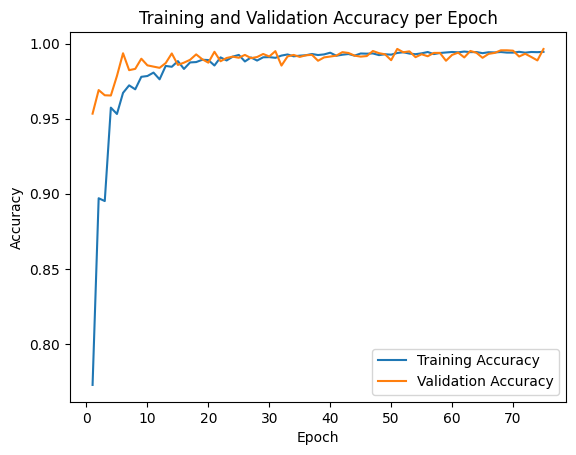

In [16]:
train_acc_history = history['train_accuracy']
val_acc_history = history['val_accuracy']

print('train acc: ', np.max(train_acc_history))
print('validation acc: ', np.max(val_acc_history))

plotter = AccPlotter(train_acc_history, val_acc_history)
plotter.plot()

### Loading and testing the trained model

In [65]:
model_path = SAVING_DIR

best_model_path = os.path.join(model_path, 'best_model_'+str(NUM_EPOCHS)+'.pth')
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

print('Model loaded successfully from best_model_'+str(NUM_EPOCHS)+'.pth')

Model loaded successfully from best_model_75.pth


In [51]:
weight = torch.tensor(
          [[0.30],  # class 0 (water) 
          [0.05],   # class 1 (land)
          [0.50],   # class 2 (non-bs to bs)
          [0.15]],  # class 3 (bs) 
    device=DEVICE)

# Initialize the LossComputation and MyAccuracy classes
loss_computer = LossComputation(DEVICE, BATCH_SIZE, SIZE, NUM_CLASSES, weight)
accuracy_metric = MyAccuracy(BATCH_SIZE, SIZE, NUM_CLASSES).to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [52]:
model.eval()
test_loss = 0.0
accuracy_metric.reset()

# saving tensors as numpy to apply a heatmap (optional)
yy_hat_loaded = []
yy_class_loaded = []

first_batch = True

with torch.no_grad():
    for batch_num, (x, y) in enumerate(test_dataloader):
        print(f"{batch_num+1}, ", end="")
        
        # Preprocess inputs
        x = torch.transpose(x, 1, 2).to(DEVICE)
        y = torch.transpose(y, 1, 2).squeeze().to(DEVICE)
        
        # Forward pass
        y_hat = model(x)
        y_hat = y_hat.squeeze()  # match the shape of y

        yy = target_mask(y[:,0], BATCH_SIZE, SIZE).to(DEVICE)
        yy_class = class_mask(NUM_CLASSES, y=yy).to(DEVICE)
        yy_hat = pred_mask(y_hat[:,0], BATCH_SIZE, SIZE).to(DEVICE)

        # saving the tensors to apply a heatmap
        if first_batch:
            # Save y_hat[:, 0] and yy_class only in the first batch
            yy_hat_loaded = yy_hat.cpu().numpy()
            yy_class_loaded = yy_class.cpu().numpy()
            first_batch = False

        # Compute loss
        loss = loss_computer.compute_loss(y_hat, y)
        test_loss += loss.item()

        # Update accuracy metric
        accuracy_metric.update(y_hat[:, 0], y[:, 0])

test_loss /= len(test_dataloader.sampler)
test_accuracy = accuracy_metric.compute().item()
accuracy_metric.reset()
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

1, 2, Test Loss: 1.142, Test Accuracy: 0.992


### Showing a unique sample with the target and the respective prediction  

2


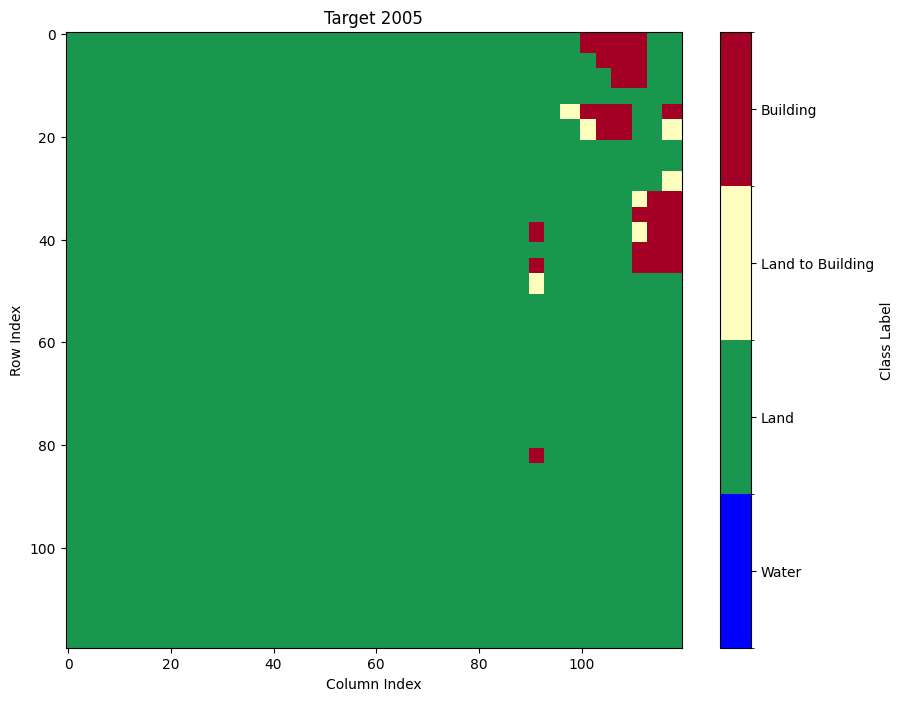

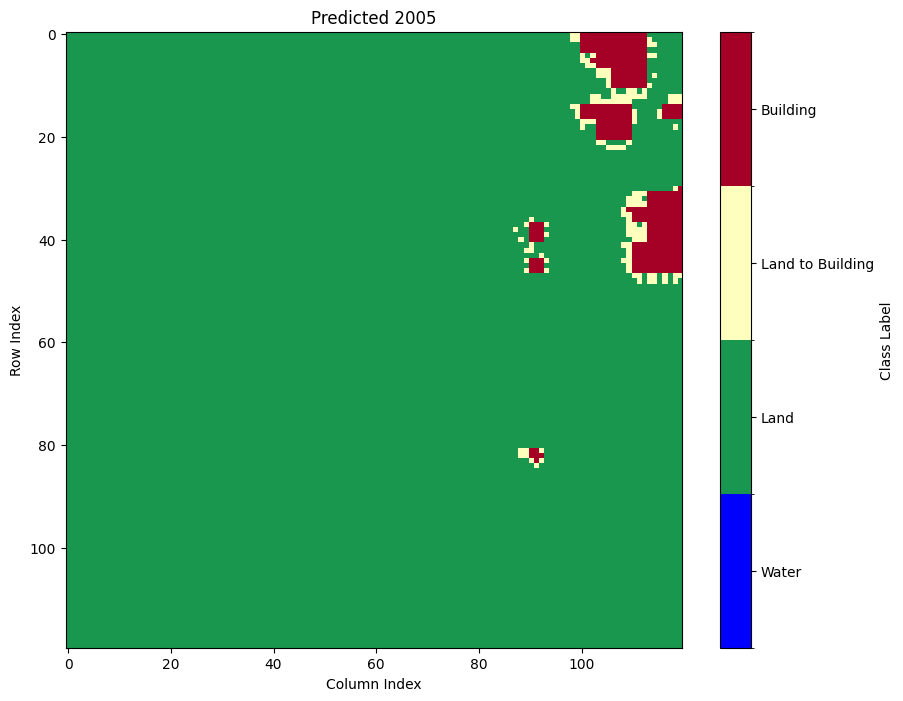

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Extract specific colors from the 'RdYlGn' colormap
base_cmap = plt.get_cmap('RdYlGn')
colors = ['blue', base_cmap(0.90), base_cmap(0.5), base_cmap(0)]  # Extract colors at specific points
cmap = ListedColormap(colors)

# [water, land, land-to-bs, bs]
# 0.0 red

for n_0 in range(2,3):

    print(n_0)
    # Define the normalization
    norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

    # Create a combined heatmap for yy_class_loaded
    first_batch_all_classes = yy_class_loaded[:, n_0] 

    # Initialize an empty array to store the class information
    combined_classes = np.zeros_like(first_batch_all_classes[0])

    # Assign each class a unique identifier (0, 1, 2, 3)
    for i in range(4):
        combined_classes[first_batch_all_classes[i] == 1] = i

    plt.figure(figsize=(10, 8))
    plt.imshow(combined_classes, cmap=cmap, norm=norm, interpolation='nearest')
    cbar = plt.colorbar(ticks=[0, 1, 2, 3], label='Class Label')
    cbar.ax.set_yticklabels(['Water', 'Land', 'Land to Building', 'Building'])
    plt.title('Target 2005')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

    # Create a heatmap for yy_hat_loaded
    first_element = yy_hat_loaded[n_0]

    plt.figure(figsize=(10, 8))
    plt.imshow(first_element, cmap=cmap, norm=norm, interpolation='nearest')
    cbar = plt.colorbar(ticks=[0, 1, 2, 3], label='Class Label')
    cbar.ax.set_yticklabels(['Water', 'Land', 'Land to Building', 'Building'])
    plt.title('Predicted 2005')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

### Showing 6 samples with the target and the respective prediction

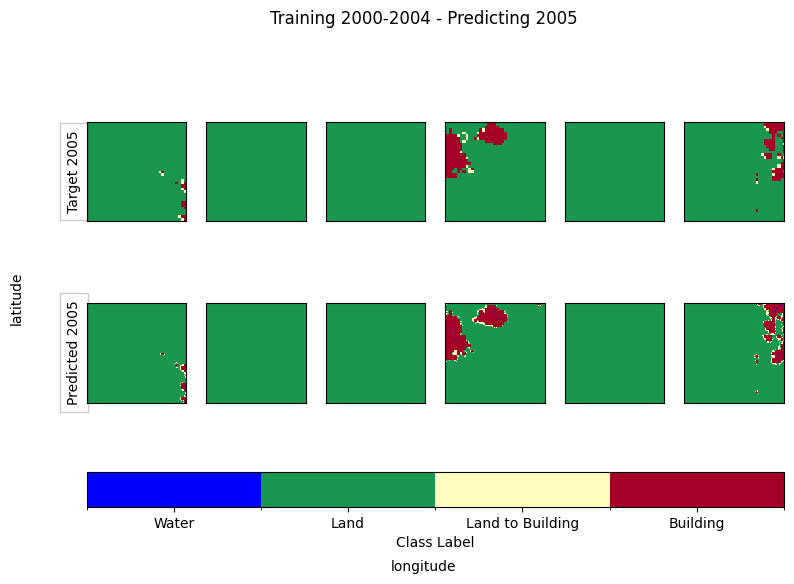

In [60]:
n_samples=6
box = dict(facecolor='white', pad=5, alpha=0.2)
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
n=10
n_0=n
first_time=True
images = []
for ax in axs.flat:
    n_0=n_0+1

    # Define the normalization
    norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)
    # Create a combined heatmap for yy_class_loaded
    first_batch_all_classes = yy_class_loaded[:, n_0] 
    # Initialize an empty array to store the class information
    combined_classes = np.zeros_like(first_batch_all_classes[0])
    # Assign each class a unique identifier (0, 1, 2, 3)
    for i in range(4):
        combined_classes[first_batch_all_classes[i] == 1] = i
    if (first_time):
        
        images.append(ax.imshow(combined_classes, cmap=cmap, norm=norm, interpolation='nearest'))
        
        if n_0==n+1:
            ax.set_ylabel('Target 2005', bbox=box)
    else:
        # Create a heatmap for yy_hat_loaded
        first_element = yy_hat_loaded[n_0]
        images.append(ax.imshow(first_element, cmap=cmap, norm=norm, interpolation='nearest'))
        if n_0==n+1:
            ax.set_ylabel('Predicted 2005', bbox=box)
    #ax.imshow(grid, interpolation=interp_method, cmap='viridis')
    #ax.set_title(str(interp_method))
    if n_0==(n+n_samples):
        n_0 = n
        first_time=False

#cbar = plt.colorbar(ticks=[0, 1, 2, 3], label='Class Label')
#cbar.ax.set_yticklabels(['Water', 'Land', 'Land to Building', 'Building'])
#fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)
cbar = fig.colorbar(images[0], ax=axs,ticks=[0, 1, 2, 3], label='Class Label', orientation='horizontal' , location='bottom', fraction=.13)
cbar.ax.set_xticklabels(['Water', 'Land', 'Land to Building', 'Building'])
fig.suptitle('Training 2000-2004 - Predicting 2005')
fig.text(0.5, 0.04, 'longitude', ha='center', va='bottom')
fig.text(0.04, 0.5, 'latitude', va='center', rotation='vertical')
plt.show()